# Tutorial 5

In [1]:
import os
import sys

# ✅ 兼容写法：使用当前工作目录
# 假设你的 Notebook 就在项目根目录下 (即与 src 文件夹同级)
src_path = os.path.join(os.getcwd(), 'src')

if src_path not in sys.path:
    sys.path.append(src_path)

import MISTIC

       MISTIC Pipeline Started

[Step 1/5] Loading and Preprocessing Data...
Found 4 files. Loading...
Loaded: 151673
Loaded: 151674
Loaded: 151675
Loaded: 151676
Number of common genes: 1134

[Step 2/5] Running BANKSY and Preparing Matrices...
Created output directory: ./output/banksy_processed
Starting BANKSY computation. Results will be saved to ./output/banksy_processed...

Median distance to closest cell = 137.00364958642524

---- Ran median_dist_to_nearest_neighbour in 0.02 s ----


Median distance to closest cell = 137.0036

---- Ran generate_spatial_distance_graph in 0.01 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.13 s ----

---- Ran generate_spatial_distance_graph in 0.02 s ----

---- Ran theta_from_spatial_graph in 0.04 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.19 s ----

----- Plotting theta Graph -----
Runtime Dec-21-2025-17-06

1134 genes to be analysed:
Gene List:


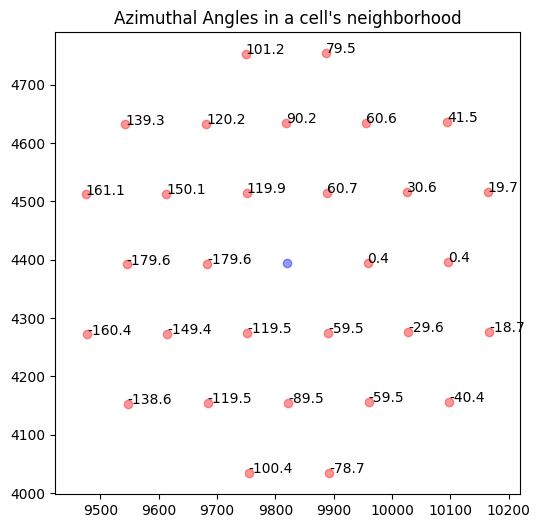

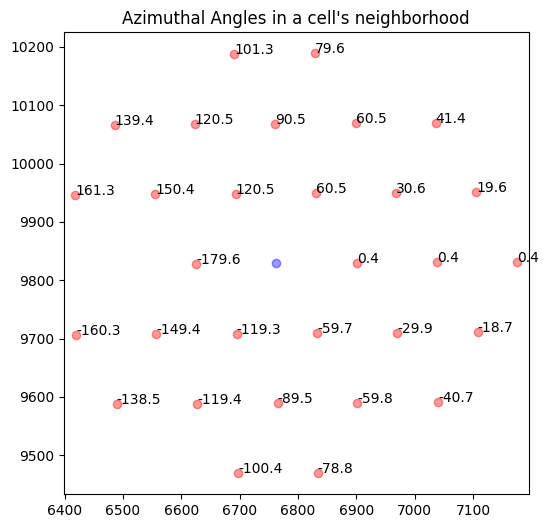

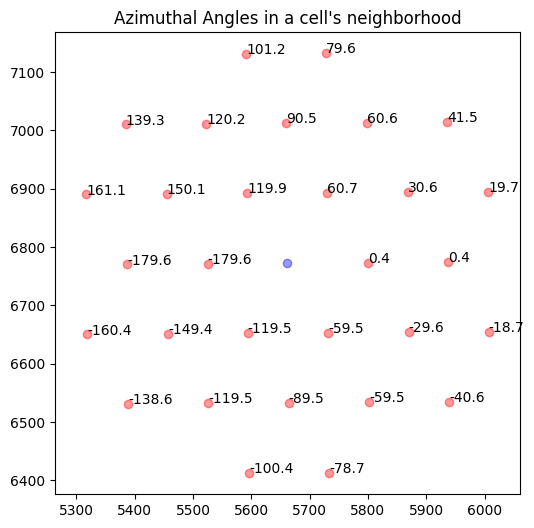

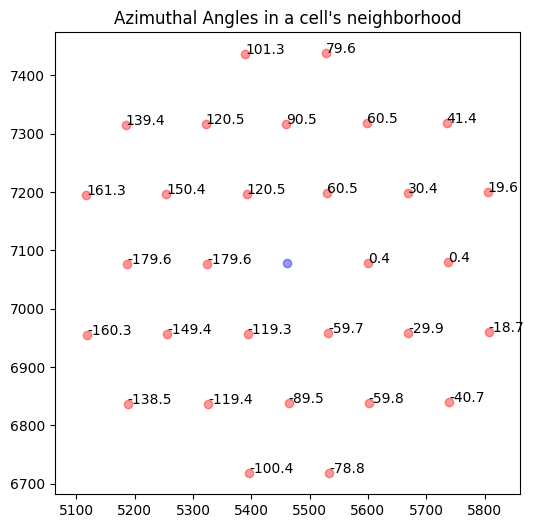

In [2]:
INPUT_DIR = os.path.join('data', 'IVH')
OUTPUT_BANKSY_DIR = "./output/banksy_processed"

OUTPUT_FILE = os.path.join('output', 'mistic_result.h5ad')
# Preprocessing
N_TOP_GENES = 5000
# Graph Construction Parameters
SPATIAL_NEIGHBORS = 6  # k for spatial graph
SPATIAL_RADIUS = 150.0  # Radius for spatial graph
# Model Training Parameters
IS_HETEROGENEOUS = True  # Use GCN for output layer if True & dense MNN
NUM_EPOCHS = 500
CONTRASTIVE_WEIGHT = 0.05  # Coefficient for contrastive loss
LEARNING_RATE = 0.001
SEED = 42
print("==========================================")
print("       MISTIC Pipeline Started")
print("==========================================")
# ==========================================
# 2. Load and Preprocess
# ==========================================
print("\n[Step 1/5] Loading and Preprocessing Data...")
# Load .h5ad files and perform normalization
raw_adatas, filenames = MISTIC.load_and_preprocess(INPUT_DIR,n_top_genes=N_TOP_GENES)
# Align genes across all slices (intersection)
aligned_adatas = MISTIC.align_common_genes(raw_adatas)

# ==========================================
# 3. Generate BANKSY Features
# ==========================================
print("\n[Step 2/5] Running BANKSY and Preparing Matrices...")

# Compute Banksy matrices and concatenate original data
# Note: raw_adatas memory is cleared inside this function
adata_concat = MISTIC.get_banksy_results(aligned_adatas,filenames,output_dir = OUTPUT_BANKSY_DIR )

In [3]:
adata_concat.obs

,in_tissue,array_row,array_col,Ground Truth,slice_labels,slice_name
0_AAACAAGTATCTCCCA-1,1,50,102,Layer_3,151673,151673
0_AAACAATCTACTAGCA-1,1,3,43,Layer_1,151673,151673
0_AAACACCAATAACTGC-1,1,59,19,WM,151673,151673
0_AAACAGAGCGACTCCT-1,1,14,94,Layer_3,151673,151673
0_AAACAGCTTTCAGAAG-1,1,43,9,Layer_5,151673,151673
...,...,...,...,...,...,...
3_TTGTTGTGTGTCAAGA-1,1,31,77,Layer_6,151676,151676
3_TTGTTTCACATCCAGG-1,1,58,42,WM,151676,151676
3_TTGTTTCATTAGTCTA-1,1,60,30,WM,151676,151676
3_TTGTTTCCATACAACT-1,1,45,27,Layer_6,151676,151676


In [4]:
X_adata, X_expr, X_gra, adj_concat, spatial_adj_concat, avg_mnn = MISTIC.construct_graph(banksy_dir=OUTPUT_BANKSY_DIR)
        

Loading files from ./output/banksy_processed...
Processing 151673_banksy.h5ad...
  --> Average degree: 28.9045
Processing 151674_banksy.h5ad...
  --> Average degree: 28.9689
Processing 151675_banksy.h5ad...
  --> Average degree: 29.1486
Processing 151676_banksy.h5ad...
  --> Average degree: 29.0737
Concatenating data...
Constructing block diagonal matrices...
Computing Cross-Slice MNN...
MNN Average Degree: 12.1293
Cleaning up intermediate directory: ./output/banksy_processed
Cleanup successful.


In [5]:
IS_HETEROGENEOUS = False
CONTRASTIVE_WEIGHT = 0.5

In [6]:
print("\n[Step 4/5] Training MISTIC AutoEncoder...")

# Run the training loop
adata_result, model = MISTIC.run_training(
    adata_concat=adata_concat,
    X_adata=X_adata,
    X_expr=X_expr,
    X_gra=X_gra,
    adj_concat=adj_concat,
    spatial_adj_concat=spatial_adj_concat,
    mnn_avg_degree=avg_mnn,
    # Parameters
    is_heterogeneous=IS_HETEROGENEOUS,
    num_epochs=NUM_EPOCHS,
    contrastive_weight=CONTRASTIVE_WEIGHT,
    lr=LEARNING_RATE,
    seed=SEED
)

    # ==========================================
    # 6. Save Results
    # ==========================================
print(f"\n[Step 5/5] Saving results to {OUTPUT_FILE}...")

adata_result.write_h5ad(OUTPUT_FILE)


[Step 4/5] Training MISTIC AutoEncoder...
Running training on: cuda
Hyperparameters -> Heterogeneous: False, Epochs: 500, Contrastive Weight: 0.5
Preparing tensors and graphs...
Generating contrastive learning pairs...
Initializing AutoEncoder (Heterogeneous=False, MNN_Avg_Deg=12.13)...
Starting training for 500 epochs...


Training MISTIC: 100%|██████████| 500/500 [01:05<00:00,  7.68epoch/s, Con=0.2542, Rec=0.8639, Total_Loss=0.9911]


Training finished. Extracting embeddings...
Embedding saved to adata_concat.obsm['MISTIC']

[Step 5/5] Saving results to output/mistic_result.h5ad...


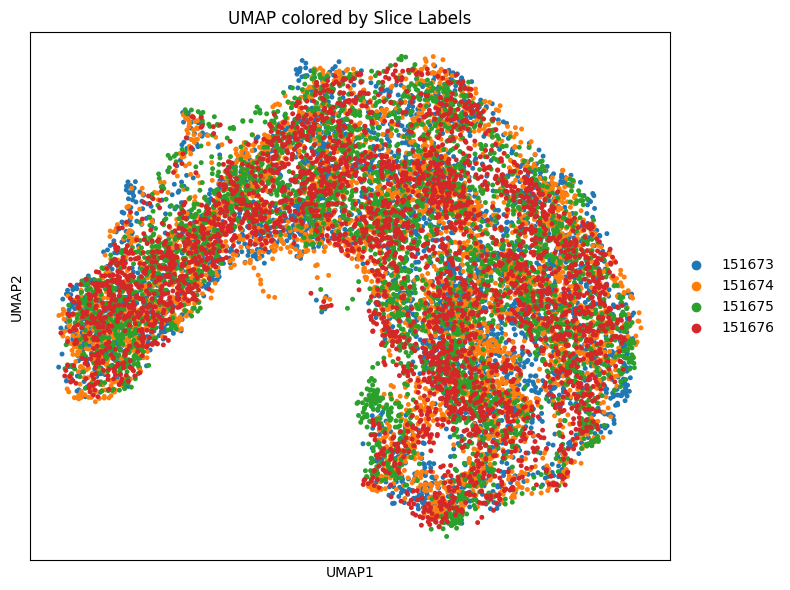

In [7]:
import scanpy as sc
import matplotlib.pyplot as plt
sc.pp.neighbors(adata_result, use_rep='MISTIC', n_neighbors=15)
sc.tl.umap(adata_result,random_state=42)

def plot_umap(adata_result, color_by, title=None, save_path=None):

    fig, ax = plt.subplots(figsize=(8, 6))

    sc.pl.umap(
        adata_result,
        color=color_by,
        show=False,
        title=title,
        frameon=True,
        ax=ax,
        size=50,
        legend_loc='right margin',
        legend_fontsize=10,
        legend_fontoutline=2
    )


    plt.tight_layout()

    if save_path:

        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:

        plt.show()

# slice_labels UMAP
plot_umap(adata_result, color_by=['slice_labels'], title='UMAP colored by Slice Labels')